In [2]:
import normalize
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction import DictVectorizer
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, recall_score, precision_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest, RFE, VarianceThreshold
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.over_sampling import SMOTE
import pandas as pd 
import numpy as np 
from numpy import inf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.formula.api as sm
from collections import Counter
warnings.filterwarnings("ignore")
%matplotlib inline

# Methods

In [3]:
def show_kbest(data_frame, target, linear_rel=True, k=4):
    """
    Selecting K-Best features for classification
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    scores = []
    if linear_rel == True: 
        feat_selector = SelectKBest(f_classif, k=k)
        _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
        col_name = "F Score"
    else:
        feat_selector = SelectKBest(mutual_info_classif, k=k)
        _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
        col_name = "Mutual Information"
    
    feat_scores = pd.DataFrame()
    feat_scores[col_name] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores 

def preprocess_data_frame(data_frame, columns):
    """
    Dummifying and encoding variables of dataframe, droping rows with NAN values
    :param data_frame: A pandas DataFrame to be processed
    pandas DataFrame
    :param columns: List of column names of categorical variables 
    :returns data_frame: encoded variable DataFrame
    """
    data_frame = data_frame.dropna()
    data_frame = data_frame.reset_index(drop=True)
    
    for col in columns:
#         print(data_frame[col])
        data_frame[col] = encode_variable(data_frame[col])
#         print(data_frame[col])
    data_frame = pd.get_dummies(data_frame)
    return data_frame
    
def encode_variable(series):
    """
    Encoding categorical variables to numericial values
    :param series: A pandas Series with categorical values
    pandas DataFrame
    :returns data_frame: encoded variable DataFrame
    """
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(series)
    print(list(le.classes_))
    print(set(le.transform(series))) 
    data_frame = pd.DataFrame({
        series.name: le.transform(series)
    })
    return data_frame
    
def split_dataframe(data_frame, target):
    """
    Split dataframe to predictors and target
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :returns DataFrames: X (predictors) and y (target) dataframes 
    """
    X = data_frame.drop([target], axis=1)
    y = encode_variable(data_frame[target])
    return X, y 

def get_features_variance_threshold(data_frame,target="gender", threshold=0.2):
    """
    Returns list of features with a variance above the specified threshold
    :param data_frame: A pandas dataFrame with the training data
    :param threshold: float value between 0 and 1 
    :returns feature_scores: list of features
    """
    if target in data_frame.columns:
        data_frame = data_frame.drop([target], axis=1)
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(data_frame)
    # Get the indices of zero variance feats
    feat_ix_keep = selector.get_support(indices=True)
#     print(feat_ix_keep)
    return data_frame.columns[feat_ix_keep]

def get_features_univariate(data_frame, k=5, linear=True, target="gender"):
    """
    Returns list of features selected using the specified univariate method
    :param data_frame: A pandas dataFrame with the training data
    :param k: top k features to select  
    :returns data_frame: with selected features
    """
    df = show_kbest(data_frame,target=target,linear_rel=linear, k=k)
    df = df[df["Support"] == True]
    columns = df["Attribute"].values
    return columns

def get_features_rfe(data_frame,model,k=5):
    """
    Returns list of features (k specified) selected using RFE for
    :param data_frame: A pandas dataFrame with features and labels
    :param k: top k features to select  
    :returns list: most relevant features 
    """
    X = data_frame.drop("gender", axis=1)
    y = data_frame["gender"]
    selector = RFE(model, k, step=1)
    selector = selector.fit(X, y)
#     print(selector.support_)
    df = pd.DataFrame({
        "feature": X.columns,
        "support": selector.support_
    })
    return list(df[df["support"] == True]["feature"])

    
    
def under_sample(X,y):
    """ Returns resampled features and labels
    :param X: Features data frame
    :param y: Label data frame
    :return X_resampled, y_resampled: Numpy features array and corresponding lable array
    """
    rus = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rus.fit_sample(X, y)
    print(sorted(Counter(y_resampled).items()))
    return X_resampled, y_resampled

def generate_classification_report(X_train, X_test, y_train, y_test, model):
    """ Prints classification report
    :param X: Features data frame
    :param y: Label data frame
    :param model: Sklearn model object
    """
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#     y_test = list(np.array(y_test).flatten())
#     y_train = list(np.array(y_train).flatten())
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    target_names = ['female', 'male']
    mean = cross_val_score(model, X_test, y_test, cv=10, scoring="accuracy").mean()
    var = cross_val_score(model, X_test, y_test, cv=10, scoring="accuracy").var()
#     print("Cross Validated Accuracy: mean - {}, var - {}".format(mean, var))
    print("Accuracy Score: {} Var: {}".format(mean, var))
    print("\nConfusion Matrix:\n")
    print(confusion_matrix(y_test, pred))
    print("\nClassification Report:\n")
    print(classification_report(y_test, pred, target_names=target_names))
    
def change_of_evaluation_rfe(X_train, X_test,y_train,y_test,model, metric="precision"):
    """
    Plots accuracy with respect to the number of features left, and prints the names of features
    :param X_train: A pandas dataFrame with train features
    :param X_test: A pandas dataFrame with test features
    :param y_train: A pandas dataFrame with train labels
    :param y_test: A pandas dataFrame with test labels
    :param model: Sklearn classification model object
    :param metric: Metric to show: precision, recall, accuracy
    :return num_features: Returns the top k features to be selected
    """
    base = pd.concat([pd.concat([X_train,X_test]), pd.concat([y_train,y_test])], axis=1)
    X = pd.concat([X_train,X_test])
    y = pd.concat([y_train,y_test])
    score = []
    for k in range(len(X.columns),0,-1):
        columns = get_features_rfe(base,model,k)
        X_tr = X_train[columns]
        X_te = X_test[columns]

        model.fit(X_tr, y_train)
        mean = cross_val_score(model, X_te, y_test, cv=10, scoring=metric).mean()
        variance = cross_val_score(model, X_te, y_test, cv=10).var()

        score.append([k, mean, variance])

    df = pd.DataFrame(score, columns=["num_features", "mean","variance"])
    sns.pointplot(df["num_features"], df["mean"])
    plt.show()
    return df.sort_values("mean", ascending=False)[["num_features"]].values[0][0]

def change_of_evaluation_univariate_feature_selection(X_train, X_test, y_train, y_test,model, metric="precision", linear=True):
    """
    Plots accuracy with respect to the number of features left, and prints the names of features
    :param X_train: A pandas dataFrame with train features
    :param X_test: A pandas dataFrame with test features
    :param y_train: A pandas dataFrame with train labels
    :param y_test: A pandas dataFrame with test labels
    :param linear: If true > F-score if false > mutual information
    :param model: Sklearn classification model object
    :param metric: Metric to show: precision, recall, accuracy
    :return num_features: Returns the top k features to be selected
    """
    X = pd.concat([X_train,X_test])
    y = pd.concat([y_train,y_test])
    data = pd.concat([X,y], axis=1)
    score = []
    for k in range(len(X.columns),0,-1):
        df = show_kbest(data,"gender",linear_rel=linear, k=k)
        df = df[df["Support"] == True]
        columns = df["Attribute"].values
        X_tr = X_train[columns]
        X_ts = X_test[columns]

        model.fit(X_tr, y_train)
        mean = cross_val_score(model, X_ts, y_test, cv=10, scoring=metric).mean()
        variance = cross_val_score(model, X_ts, y_test, cv=10).var()

        score.append([k, mean, variance])

    df = pd.DataFrame(score, columns=["num_features", "mean","variance"])
    sns.pointplot(df["num_features"], df["mean"])
    plt.show()
    return df.sort_values("mean", ascending=False)[["num_features"]].values[0][0]

def change_of_evaluation_variance_threshold(X_train, X_test, y_train, y_test,model,metric="precision"):
    """
    Plots accuracy with respect to the number of features left, and prints the names of features
    :param X_train: A pandas dataFrame with train features
    :param X_test: A pandas dataFrame with test features
    :param y_train: A pandas dataFrame with train labels
    :param y_test: A pandas dataFrame with test labels
    :param model: Sklearn classification model object
    :param metric: Metric to show: precision, recall, accuracy
    """
    lst = list(np.arange(0.0, 1.0, 0.1))
    X = pd.concat([X_train,X_test])
    y = pd.concat([y_train,y_test])
    score = []
    for k in lst:
        features = get_features_variance_threshold(X, threshold=k)
        
        X_train = X_train[features]
        X_test = X_test[features]
        
#         print("Variance: {} - features: {}".format(k,features))

        model.fit(X_train, y_train)
        mean = cross_val_score(model, X_test, y_test, cv=10).mean()
        variance = cross_val_score(model, X_test, y_test, cv=10).var()
        score.append([k, mean, variance])
#     print(score)
    df = pd.DataFrame(score, columns=["variance", "mean", "std"])
    sns.pointplot(df["variance"], df["mean"])
    plt.show()
    return df.sort_values("mean", ascending=False)[["variance"]].values[0][0]
    
def full_report(X_train, X_test, y_train, y_test, model):
    """ Prints classification report for model over different feature selection models
    :param X_train: A pandas dataFrame with train features
    :param X_test: A pandas dataFrame with test features
    :param y_train: A pandas dataFrame with train labels
    :param y_test: A pandas dataFrame with test labels
    :param model: Sklearn object
    """
    X = pd.concat([X_train, X_test])
    y = pd.concat([y_train, y_test])
    
    base = pd.concat([X,y], axis=1)
    print("""###############################################################""")
    print("""Feature Selection: F-SCORE: \n""")
    k = change_of_evaluation_univariate_feature_selection(X_train, X_test, y_train, y_test,
                                                              model, metric="accuracy")
    features = get_features_univariate(base, k=k, linear=True)
    print("Number of features: ", len(features))
    print("Features: ", features)
    generate_classification_report(X_train, X_test, y_train, y_test, r_forest)
    print("""###############################################################""")
    print("""Feature Selection: MUTUAL INFORMATION: \n""")

    k = change_of_evaluation_univariate_feature_selection(X_train, X_test, y_train, y_test,
                                                              model,linear=False, metric="accuracy")
    features = get_features_univariate(base, k=k, linear=False)
    print("Number of features: ", len(features))
    print("Features: ", features)
    generate_classification_report(X_train, X_test, y_train, y_test, r_forest)
    print("""###############################################################""")
    print("""Feature Selection: Variance Threshold: \n""")
    v = change_of_evaluation_variance_threshold(X_train, X_test, y_train, y_test,model, metric="accuracy")
#     print(v)
    features = get_features_variance_threshold(base,threshold=v)
    print("Number of features: ", len(features))
    print("Features: ", features)
    generate_classification_report(X_train, X_test, y_train, y_test, r_forest)
    
    print("""###############################################################""")
    print("""Feature Selection: RFE: \n""")
    k = change_of_evaluation_rfe(X_train, X_test, y_train, y_test,
                                 model,metric='accuracy')
    features = get_features_rfe(base,model, k=k)
    print("Number of features: ", len(features))
    print("Features: ", features)
    generate_classification_report(X_train, X_test, y_train, y_test, model)



In [4]:
def over_sample(X,y):
    """
    Does the hybrid oversampling with SMOTE
    :param X: Dataframe with predictor atributes
    :param y: Dataframe with labels
    :return X_resampled, y_resampled:
    """
    sm = SMOTE(random_state=42)
    X,y = sm.fit_sample(X, y)
    print(X.shape, y.shape)
    return X,y

def train_test_dfs(X,y,test_size=0.2):
    """
    Returns train, test dataframees
    :parma X: data frame with predictor atributes 
    :parma y: data frame with labels 
    :parma test_size: fraction of data set to be assigned to the test set
    :return X_train, X_test, y_train, y_test:
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)
    y_train = pd.DataFrame(y_train, columns=y.columns)
    y_test = pd.DataFrame(y_test, columns=y.columns)
    return X_train, X_test, y_train, y_test

def evaluate_model(estimator, X_train, X_test, y_train, y_test): 
    """
    Prints accuracy, confusion matrix and classification report
    """
    target_names = ['female', 'male']
    estimator.fit(X_train,y_train)
    print(accuracy_score(y_test, estimator.predict(X_test)))
    print(confusion_matrix(y_test, estimator.predict(X_test)))
    print(classification_report(y_test, estimator.predict(X_test), target_names=target_names))
    
def get_ac_pr_re_f1(estimator, X,y):
    """
    Returns:
    Accuracy, Precission, Recall, F1-Score
    """
    estimator.fit(X_train,y_train)
    predict = estimator.predict(X_test)
    acc = cross_val_score(estimator, X,y,scoring="accuracy", cv=10).mean()
    re = cross_val_score(estimator, X,y,scoring="recall", cv=10).mean()
    pr = cross_val_score(estimator, X,y,scoring="precision", cv=10).mean()
    f1 = cross_val_score(estimator, X,y,scoring="f1", cv=10).mean()
    return acc,pr,re,f1

def model_comparison_df(estimator_dict, X,y):
    """
    Returns table with model performance comparisson
    """
    lst = []
    for k,v in estimator_dict.items():
        acc, pr, re, f1 = get_ac_pr_re_f1(v, X,y)
        lst.append([k, acc, pr, re, f1])
    return pd.DataFrame(lst, columns=["Algorithm", "Accuracy", "Precision", "Recall", "F1"])

def print_latex(df, col_format="|c|c|c|c|c|"):
    """ Prints the latex syntax equivalent to the passed dataframe
    :param df: Pandas dataframe 
    :col_format : String indicating the format of columns
    """
    df = df.round(2)
    latex = df.to_latex(column_format=col_format, index=False).replace('toprule',
                                            "hline").replace('midrule',
                                            "hline").replace('bottomrule',
                                            "hline").replace("\\\\\n",
                                            "\\\\\n\\hline").replace("\hline\hline","\hline")
    print(latex)

In [5]:
# get_ac_pr_re_f1(r_forest,X_over,y_over)

# Load the data

In [6]:
data = pd.read_pickle("../data/final_sets/countries/model_large/2016_german")

# Preprocess and Normalize

In [7]:
data = preprocess_data_frame(data, ["gender"])
data.gender.value_counts()

['female', 'male']
{0, 1}


1    1136
0     171
Name: gender, dtype: int64

   index  gender  entered  efficiency  eig_central  in_degree    k_core  \
0      0       1     2011     0.72752    -0.293665  -0.716639 -0.957751   

   out_degree     views  age       ...         party1  party2  party3  \
0    -0.69084 -0.360073   70       ...              0       0       0   

   other_p  is_alive_no  is_alive_unknown  is_alive_yes  year_interval_1  \
0        1            1                 0             0                0   

   year_interval_2  year_interval_3  
0                0                1  

[1 rows x 37 columns]


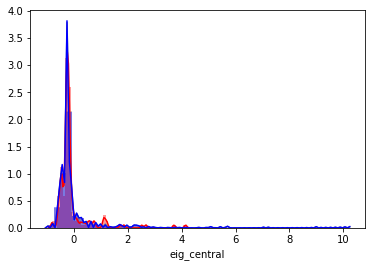

In [8]:
data = normalize.zscore_wikipedia_entered(data, ["views", "eig_central","in_degree","k_core","out_degree","efficiency"])
print(data.head(1))
data.head()

sns.distplot(data.eig_central, color="grey")
sns.distplot(data[data["gender"]==0].eig_central, color="red")
sns.distplot(data[data["gender"]==1].eig_central, color="blue")



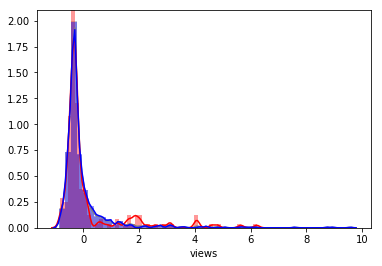

In [9]:
sns.distplot(data.views, color="grey")
sns.distplot(data[data["gender"]==0].views, color="red")
sns.distplot(data[data["gender"]==1].views, color="blue")



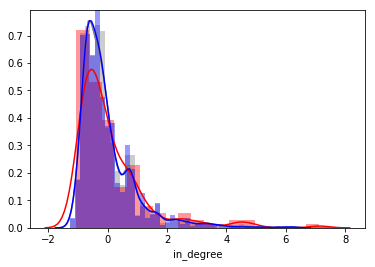

In [10]:
sns.distplot(data.in_degree, color="grey")
sns.distplot(data[data["gender"]==0].in_degree, color="red")
sns.distplot(data[data["gender"]==1].in_degree, color="blue")


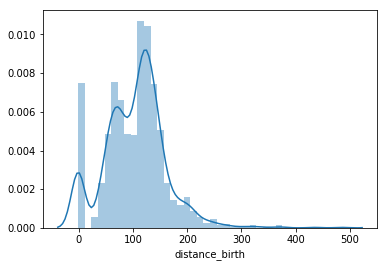

In [11]:
sns.distplot(data["distance_birth"])

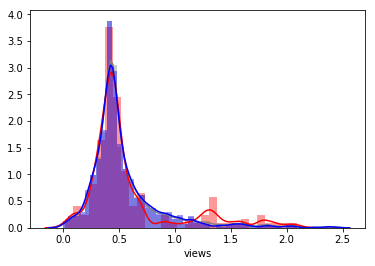

In [12]:
data = normalize.normalize(data, ["eig_central","in_degree","k_core","out_degree","efficiency","views"])

sns.distplot(data.views, color="grey")
sns.distplot(data[data["gender"]==0].views, color="red")
sns.distplot(data[data["gender"]==1].views, color="blue")
#data["views"].hist()

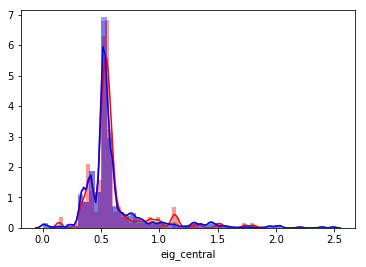

In [13]:
sns.distplot(data.eig_central, color="grey")
sns.distplot(data[data["gender"]==0].eig_central, color="red")
sns.distplot(data[data["gender"]==1].eig_central, color="blue")

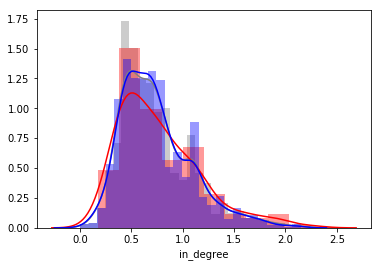

In [14]:
sns.distplot(data.in_degree, color="grey")
sns.distplot(data[data["gender"]==0].in_degree, color="red")
sns.distplot(data[data["gender"]==1].in_degree, color="blue")

In [15]:
data.shape

(1307, 37)

In [16]:
data.gender.value_counts()

1    1136
0     171
Name: gender, dtype: int64

# Machine Learning

In [17]:
X,y=split_dataframe(data,"gender")

[0, 1]
{0, 1}


In [18]:
X.head()

,index,entered,efficiency,eig_central,in_degree,k_core,out_degree,views,age,distance_birth,...,party1,party2,party3,other_p,is_alive_no,is_alive_unknown,is_alive_yes,year_interval_1,year_interval_2,year_interval_3
0,0,2011,1.731900,0.505491,0.433983,0.729934,0.511861,0.400914,70,142,...,0,0,0,1,1,0,0,0,0,1
1,1,2012,1.644144,0.531275,1.127265,1.385309,0.941523,0.371223,73,128,...,0,0,0,1,1,0,0,0,0,1
2,2,2009,1.253683,0.526813,0.405586,1.212989,1.070414,1.895638,60,114,...,0,0,0,1,1,0,0,0,1,0
3,3,2009,1.731099,0.526968,0.695952,0.945783,0.581808,0.403154,71,103,...,0,0,0,1,1,0,0,0,1,0
4,4,2011,1.419928,2.031013,1.000702,1.269519,0.784610,1.693024,48,166,...,0,0,0,1,1,0,0,0,0,1


In [19]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# y_test = list(np.array(y_test.values).flatten())
# y_train = list(np.array(y_train.values).flatten())

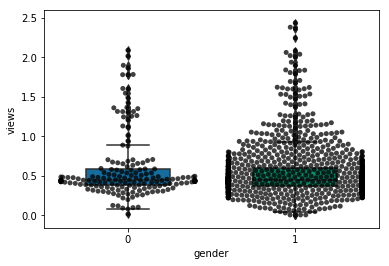

In [20]:
#data.boxplot(column="views", by="gender")

# plot boxplot with seaborn
bplot=sns.boxplot(y='views', x='gender', 
                 data=data, 
                 width=0.5,
                 palette="colorblind")
 
# add swarmplot
bplot=sns.swarmplot(y='views', x='gender',
              data=data, 
              color='black',
              alpha=0.75)


# Algorithms

In [21]:
# SVM
s_vm = svm.SVC()
# Logistic regression
log_reg = LogisticRegression()
# Decision Tree
d_tree = tree.DecisionTreeClassifier()
# Random Forest
r_forest = RandomForestClassifier()

estimator_dict = {
    "SVM": s_vm,
    "Logistic Regression": log_reg,
    "Decision Tree": d_tree,
    "Random Forest": r_forest
}

# Oversampling 

In [22]:
X_over, y_over = over_sample(X,y)
X_over = pd.DataFrame(X_over, columns=X.columns)
y_over = pd.DataFrame(y_over, columns=["gender"])
y_over["gender"].value_counts()

(2272, 36) (2272,)


1    1136
0    1136
Name: gender, dtype: int64

In [23]:
X_train, X_test, y_train, y_test = train_test_dfs(X_over,y_over)

print(y_train["gender"].value_counts())
print(y_test["gender"].value_counts())

0    909
1    908
Name: gender, dtype: int64
1    228
0    227
Name: gender, dtype: int64


In [24]:
# y_train["gender"].value_counts()

In [25]:
#this was never used!!!

#X_train_norm = normalize.zscore_wikipedia_entered(X_train, columns=["eig_central","in_degree","k_core","out_degree","views"])
#X_test_norm = normalize.zscore_wikipedia_entered(X_test, columns=["eig_central","in_degree","k_core","out_degree","views"])

#X_train_norm = normalize.normalize(X_train_norm, columns=["eig_central","in_degree","k_core","out_degree","views"])
#X_test_norm = normalize.normalize(X_test_norm, columns=["eig_central","in_degree","k_core","out_degree","views"])

## SVM

In [26]:
cross_val_score(s_vm,X_over,y_over,scoring='accuracy',cv=10)

array([0.85526316, 0.87280702, 0.86842105, 0.83333333, 0.84649123,
       0.85526316, 0.85840708, 0.85840708, 0.8539823 , 0.88053097])

## Logistic Regression

In [27]:
cross_val_score(log_reg,X_over,y_over,scoring='accuracy',cv=10)

array([0.6754386 , 0.64035088, 0.81140351, 0.71491228, 0.8245614 ,
       0.80263158, 0.80973451, 0.80973451, 0.75221239, 0.72123894])

In [28]:
evaluate_model(log_reg, X_train, X_test, y_train, y_test)

0.7648351648351648
[[187  40]
 [ 67 161]]
             precision    recall  f1-score   support

     female       0.74      0.82      0.78       227
       male       0.80      0.71      0.75       228

avg / total       0.77      0.76      0.76       455



## Decision Tree 

In [29]:
cross_val_score(d_tree,X_over,y_over,scoring='accuracy',cv=10)

array([0.45175439, 0.65789474, 0.85526316, 0.69298246, 0.89473684,
       0.93421053, 0.89380531, 0.87168142, 0.90707965, 0.89823009])

In [30]:
evaluate_model(d_tree, X_train, X_test, y_train, y_test)

0.8835164835164835
[[205  22]
 [ 31 197]]
             precision    recall  f1-score   support

     female       0.87      0.90      0.89       227
       male       0.90      0.86      0.88       228

avg / total       0.88      0.88      0.88       455



## Random Forest

In [31]:
cross_val_score(r_forest,X_over,y_over,scoring='accuracy',cv=10)

array([0.63596491, 0.79385965, 0.93421053, 0.90350877, 0.95614035,
       0.96052632, 0.94690265, 0.92920354, 0.90265487, 0.84955752])

In [32]:
evaluate_model(r_forest, X_train, X_test, y_train, y_test)

0.9054945054945055
[[209  18]
 [ 25 203]]
             precision    recall  f1-score   support

     female       0.89      0.92      0.91       227
       male       0.92      0.89      0.90       228

avg / total       0.91      0.91      0.91       455



## Comparison

In [33]:
df = model_comparison_df(estimator_dict, X_over,y_over)

In [34]:
df

,Algorithm,Accuracy,Precision,Recall,F1
0,SVM,0.858291,0.798367,0.960402,0.871481
1,Logistic Regression,0.756222,0.786582,0.698152,0.736387
2,Decision Tree,0.813255,0.873266,0.746825,0.791276
3,Random Forest,0.859595,0.922949,0.847687,0.879889


In [35]:
print_latex(df, col_format="|c|c|c|c|c|")

\begin{tabular}{|c|c|c|c|c|}
\hline
           Algorithm &  Accuracy &  Precision &  Recall &    F1 \\
\hline
                 SVM &      0.86 &       0.80 &    0.96 &  0.87 \\
\hline Logistic Regression &      0.76 &       0.79 &    0.70 &  0.74 \\
\hline       Decision Tree &      0.81 &       0.87 &    0.75 &  0.79 \\
\hline       Random Forest &      0.86 &       0.92 &    0.85 &  0.88 \\
\hline
\end{tabular}



# Undersampling

In [36]:
X_under, y_under = under_sample(X,y)
X_under = pd.DataFrame(X_under, columns=X.columns)
y_under = pd.DataFrame(y_under, columns=["gender"])
# base = pd.concat([X_resampled, y_resampled], axis=1)
# base.head()

[(0, 171), (1, 171)]


In [37]:
X_train, X_test, y_train, y_test = train_test_dfs(X_under,y_under)

In [38]:
X_train_norm = normalize.zscore_wikipedia_entered(X_train, columns=["eig_central","in_degree","k_core","out_degree","views"])
X_test_norm = normalize.zscore_wikipedia_entered(X_test, columns=["eig_central","in_degree","k_core","out_degree","views"])

#X_train_norm = normalize.normalize(X_train_norm, columns=["eig_central","in_degree","k_core","out_degree","views"])
#X_test_norm = normalizenormalize(X_test_norm, columns=["eig_central","in_degree","k_core","out_degree","views"])

## SVM

In [39]:
evaluate_model(s_vm, X_train, X_test, y_train, y_test)

0.34782608695652173
[[ 1 45]
 [ 0 23]]
             precision    recall  f1-score   support

     female       1.00      0.02      0.04        46
       male       0.34      1.00      0.51        23

avg / total       0.78      0.35      0.20        69



## Logistic Regression

In [40]:
evaluate_model(log_reg, X_train, X_test, y_train, y_test)

0.7681159420289855
[[34 12]
 [ 4 19]]
             precision    recall  f1-score   support

     female       0.89      0.74      0.81        46
       male       0.61      0.83      0.70        23

avg / total       0.80      0.77      0.77        69



## Decision Tree 

In [41]:
evaluate_model(d_tree, X_train, X_test, y_train, y_test)

0.6811594202898551
[[31 15]
 [ 7 16]]
             precision    recall  f1-score   support

     female       0.82      0.67      0.74        46
       male       0.52      0.70      0.59        23

avg / total       0.72      0.68      0.69        69



## Random Forest

In [42]:
evaluate_model(r_forest, X_train, X_test, y_train, y_test)

0.782608695652174
[[36 10]
 [ 5 18]]
             precision    recall  f1-score   support

     female       0.88      0.78      0.83        46
       male       0.64      0.78      0.71        23

avg / total       0.80      0.78      0.79        69



## Comparison

In [43]:
df = model_comparison_df(estimator_dict, X_under,y_under)

In [44]:
df

,Algorithm,Accuracy,Precision,Recall,F1
0,SVM,0.488399,0.493928,0.947386,0.649236
1,Logistic Regression,0.730392,0.744634,0.724510,0.728797
2,Decision Tree,0.586275,0.572007,0.643791,0.598370
3,Random Forest,0.649346,0.739298,0.690196,0.637337


In [45]:
print_latex(df, col_format="|c|c|c|c|c|")

\begin{tabular}{|c|c|c|c|c|}
\hline
           Algorithm &  Accuracy &  Precision &  Recall &    F1 \\
\hline
                 SVM &      0.49 &       0.49 &    0.95 &  0.65 \\
\hline Logistic Regression &      0.73 &       0.74 &    0.72 &  0.73 \\
\hline       Decision Tree &      0.59 &       0.57 &    0.64 &  0.60 \\
\hline       Random Forest &      0.65 &       0.74 &    0.69 &  0.64 \\
\hline
\end{tabular}



# Countries

In [46]:
country_dict = {
    "USA": "american",
    "Germany": "german",
    "France": "french",
    "Great Britain": "british",
    "Russia": "russian"
} 

In [47]:
def compare_countries_df(country_dict, path, year, estimator):
    lst = []
    for k,v in country_dict.items():
        df = pd.read_pickle(path+str(year)+"_"+v)
        df = normalize.zscore_wikipedia_entered(df, ["views", "eig_central","in_degree","k_core","out_degree","efficiency"])
        df = normalize.normalize(df, ["views", "eig_central","in_degree","k_core","out_degree","efficiency"])
        df = preprocess_data_frame(df, ["gender"])
        if "is_alive_no" in df.columns and "distance_delta" in df.columns and "other_p" in df.columns:
            df = df.drop(["is_alive_no","distance_delta","other_p"],axis=1)
        X,y=split_dataframe(df,"gender")
        X_over, y_over = over_sample(X,y)
        X_over = pd.DataFrame(X_over, columns=X.columns)
        y_over = pd.DataFrame(y_over, columns=["gender"])
        y_over["gender"].value_counts()
        acc, pr, re, f1 = get_ac_pr_re_f1(estimator, X_over,y_over)
        lst.append([k, acc, pr, re, f1])
    return pd.DataFrame(lst, columns=["Country", "Accuracy", "Precision", "Recall", "F1"])

In [48]:
df = compare_countries_df(country_dict, "../data/final_sets/countries/model_large/", 2016, r_forest)

['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(8030, 33) (8030,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(2272, 33) (2272,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(2422, 33) (2422,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(792, 33) (792,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(1032, 33) (1032,)


In [49]:
df

,Country,Accuracy,Precision,Recall,F1
0,USA,0.834589,0.891813,0.809463,0.832162
1,Germany,0.876875,0.920453,0.845979,0.870133
2,France,0.871914,0.917470,0.818527,0.883218
3,Great Britain,0.871667,0.933155,0.851603,0.883920
4,Russia,0.923775,0.951955,0.897097,0.928449


In [50]:
print_latex(df, col_format="|c|c|c|c|c|")

\begin{tabular}{|c|c|c|c|c|}
\hline
       Country &  Accuracy &  Precision &  Recall &    F1 \\
\hline
           USA &      0.83 &       0.89 &    0.81 &  0.83 \\
\hline       Germany &      0.88 &       0.92 &    0.85 &  0.87 \\
\hline        France &      0.87 &       0.92 &    0.82 &  0.88 \\
\hline Great Britain &      0.87 &       0.93 &    0.85 &  0.88 \\
\hline        Russia &      0.92 &       0.95 &    0.90 &  0.93 \\
\hline
\end{tabular}



In [51]:
df = compare_countries_df(country_dict, "../data/final_sets/countries/model/", 2016, r_forest)

['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(8030, 19) (8030,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(2272, 19) (2272,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(2422, 19) (2422,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(792, 19) (792,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(1032, 19) (1032,)


In [52]:
df

,Country,Accuracy,Precision,Recall,F1
0,USA,0.814040,0.885412,0.761663,0.794768
1,Germany,0.850466,0.911847,0.811605,0.861542
2,France,0.863213,0.921274,0.815167,0.834681
3,Great Britain,0.844006,0.926672,0.873974,0.847265
4,Russia,0.914989,0.956269,0.904827,0.902657


In [53]:
print_latex(df, col_format="|c|c|c|c|c|")

\begin{tabular}{|c|c|c|c|c|}
\hline
       Country &  Accuracy &  Precision &  Recall &    F1 \\
\hline
           USA &      0.81 &       0.89 &    0.76 &  0.79 \\
\hline       Germany &      0.85 &       0.91 &    0.81 &  0.86 \\
\hline        France &      0.86 &       0.92 &    0.82 &  0.83 \\
\hline Great Britain &      0.84 &       0.93 &    0.87 &  0.85 \\
\hline        Russia &      0.91 &       0.96 &    0.90 &  0.90 \\
\hline
\end{tabular}



In [54]:
def important_features(X,y, estimator):
    estimator.fit(X,y)
    df = pd.DataFrame({
        "Feature": X.columns,
        "Importance": estimator.feature_importances_
    })
    return df.sort_values(by="Importance",ascending=False)

def compare_features_df(country_dict, path, year, estimator):
    lst = []
    for k,v in country_dict.items():
        df = pd.read_pickle(path+str(year)+"_"+v)
        df = preprocess_data_frame(df, ["gender"])
        if "is_alive_no" in df.columns and "distance_delta" in df.columns and "other_p" in df.columns:
            df = df.drop(["is_alive_no","distance_delta","other_p"],axis=1)
        X,y=split_dataframe(df,"gender")
        X_over, y_over = over_sample(X,y)
        X_over = pd.DataFrame(X_over, columns=X.columns)
        y_over = pd.DataFrame(y_over, columns=["gender"])
        y_over["gender"].value_counts()
        lst.append([k,important_features(X_over, y_over, estimator)])
    return lst

In [55]:
x = compare_features_df(country_dict, "../data/final_sets/countries/model_large/", 2016, r_forest)

['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(8030, 32) (8030,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(2272, 32) (2272,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(2422, 32) (2422,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(792, 32) (792,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(1032, 32) (1032,)


In [56]:
# x[1][1].reset_index(drop=True)

In [57]:
# lst = [x[1][1].reset_index(drop=True),x[2][1].reset_index(drop=True),x[3][1].reset_index(drop=True),x[4][1].reset_index(drop=True)]
# ,x[3][1],x[4][1]/
lst = [x[0][1],x[1][1],x[2][1],x[3][1],x[4][1]]

In [58]:
# df.columns

In [59]:
df = pd.concat(lst, axis=1)
# atrs = df.Feature
atrs = df.take([0], axis=1)
atrs = atrs.replace({
    "wrt":"writer",
    "sci":"scientist",
    "jur":"journalist",
    "eco":"economist",
    "hst":"historian",
    "spo":"athleate",
    "lyr":"lawyer",
    "phs":"physician",
    "act":"actor",
    "distance_birth":"d_birth",
    "distance_death":"d_death",
    "nationality_num":"nationalities",
    "occupation_num":"occupations",
    "year_interval_1":"interval_1",
    "year_interval_2":"interval_2",
    "year_interval_3":"interval_3",
    "is_alive_unknown":"alive_unknown",
    "is_alive_yes":"is_alive"
})
us = df.take([1], axis=1)
de = df.take([3], axis=1)
fr = df.take([5], axis=1)
gb = df.take([7], axis=1)
ru = df.take([9], axis=1)

# df = df.drop(df.columns[2],axis=1)
# table = pd.DataFrame({
#     "Attribute": atrs,
#     "USA": us,
#     "Germany": de,
#     "France":fr,
#     "Great Britain": gb,
#     "Russia": ru
# })
# table["Attribute"] = atrs
# table["USA"] = us
# table["Germany"] = de
# table["France"] = fr
# table["Great Britain"] = gb
# table["Russia"] = ru
table = pd.concat([atrs, us,de,fr,gb,ru],axis=1)
table

,Feature,Importance,Importance,Importance,Importance,Importance
0,entered,0.064559,0.052355,0.061346,0.052065,0.065936
1,efficiency,0.040117,0.030346,0.036820,0.048492,0.047931
2,eig_central,0.037118,0.038880,0.026586,0.066689,0.040755
3,in_degree,0.036719,0.023830,0.041447,0.044353,0.062145
4,k_core,0.036233,0.024561,0.033912,0.053267,0.068058
5,out_degree,0.039695,0.032261,0.041122,0.040098,0.029964
6,views,0.073780,0.055747,0.061886,0.078363,0.079047
7,age,0.048518,0.053349,0.053995,0.047836,0.066120
8,d_birth,0.087955,0.089432,0.063130,0.077574,0.050394
9,d_death,0.045045,0.067337,0.082955,0.035720,0.023843


In [60]:
# pd.concat(lst, axis=1).head(10)

In [61]:
# print_latex(pd.concat(lst, axis=1).head(10))

In [62]:
# us = x[0][1]["USA"] = x[0][1].apply(lambda x:x["Feature"]+" "+"({})".format(round(x["Importance"],3)), axis=1).reset_index(drop=True)
# de = x[1][1]["Germany"] = x[1][1].apply(lambda x:x["Feature"]+" "+"({})".format(round(x["Importance"],3)), axis=1).reset_index(drop=True)
# fr = x[2][1]["France"] = x[2][1].apply(lambda x:x["Feature"]+" "+"({})".format(round(x["Importance"],3)), axis=1).reset_index(drop=True)
# gb = x[3][1]["Great Britain"] = x[3][1].apply(lambda x:x["Feature"]+" "+"({})".format(round(x["Importance"],3)), axis=1).reset_index(drop=True)
# ru = x[4][1]["Russia"] = x[4][1].apply(lambda x:x["Feature"]+" "+"({})".format(round(x["Importance"],3)), axis=1).reset_index(drop=True)
# lst = [us,de,fr,gb,ru]

In [63]:
# us = x[0][1]["USA"] = x[0][1].apply(lambda x:x["Feature"], axis=1).reset_index(drop=True)
# de = x[1][1]["Germany"] = x[1][1].apply(lambda x:x["Feature"], axis=1).reset_index(drop=True)
# fr = x[2][1]["France"] = x[2][1].apply(lambda x:x["Feature"], axis=1).reset_index(drop=True)
# gb = x[3][1]["Great Britain"] = x[3][1].apply(lambda x:x["Feature"], axis=1).reset_index(drop=True)
# ru = x[4][1]["Russia"] = x[4][1].apply(lambda x:x["Feature"], axis=1).reset_index(drop=True)
# lst = [us,de,fr,gb,ru]

In [64]:
# df = pd.concat(lst,axis=1)
# df.columns = ["USA", "Germany", "France", "Great Britain", "Russia"]
# print_latex(df.head(10))

In [65]:
print_latex(table)

\begin{tabular}{|c|c|c|c|c|}
\hline
       Feature &  Importance &  Importance &  Importance &  Importance &  Importance \\
\hline
       entered &        0.06 &        0.05 &        0.06 &        0.05 &        0.07 \\
\hline    efficiency &        0.04 &        0.03 &        0.04 &        0.05 &        0.05 \\
\hline   eig\_central &        0.04 &        0.04 &        0.03 &        0.07 &        0.04 \\
\hline     in\_degree &        0.04 &        0.02 &        0.04 &        0.04 &        0.06 \\
\hline        k\_core &        0.04 &        0.02 &        0.03 &        0.05 &        0.07 \\
\hline    out\_degree &        0.04 &        0.03 &        0.04 &        0.04 &        0.03 \\
\hline         views &        0.07 &        0.06 &        0.06 &        0.08 &        0.08 \\
\hline           age &        0.05 &        0.05 &        0.05 &        0.05 &        0.07 \\
\hline       d\_birth &        0.09 &        0.09 &        0.06 &        0.08 &        0.05 \\
\hline       d\_death & 

In [66]:
log_reg.coef_

array([[ 1.19987535e-03, -5.63779641e-04,  9.42330329e-02,
         6.92677425e-01,  2.67072459e-01, -2.85859332e-01,
        -2.20018359e-01,  2.65664575e-02, -2.09713951e-02,
         1.52953109e-02,  8.12037593e-03,  7.17493498e-03,
         8.19015893e-02,  1.51916535e-01, -3.02106315e-01,
        -5.65154904e-01,  1.03420814e+00,  1.86682441e+00,
        -2.49699953e-01,  6.00744420e-01, -1.01970256e-01,
         4.79244553e-01, -3.57707488e-01,  0.00000000e+00,
        -1.01970256e-01,  6.62696008e-02, -5.92408348e-01,
         1.96469452e-01,  8.78958762e-01, -8.24069127e-02,
         9.00377137e-02,  6.72924025e-01, -7.59927476e-01,
         3.06332454e-01, -1.53098331e-01, -1.50199861e-01]])

In [67]:
# X = X.drop(["is_alive_no"], axis=1)
# print(X)
model = sm.Logit(y, X)
 
result = model.fit()

         Current function value: 0.295302
         Iterations: 35


In [68]:
def p_to_star(p_value):
    if p_value <= 0.001:
        return "***"
    if p_value <= 0.01:
        return "**"
    if p_value <= 0.05:
        return "*"
    return ""

def get_coefs_log_reg(X,y):
    # X = X.drop(["is_alive_no"], axis=1)
    # print(X)
    model = sm.Logit(y, X)
    result = model.fit(method='bfgs')
    df = pd.DataFrame({
        "Atribute": X.columns,
        "coef": result.params,
        "P-Value": result.pvalues,
    })
    df["p_value"] = df["P-Value"].apply(lambda x: p_to_star(x))
    df["Coefficient"] = df.apply(lambda x: str(round(x["coef"],3))+x["p_value"], axis=1)
    return df.round(2).drop(["coef", "p_value", "P-Value"], axis=1)

In [69]:
print_latex(get_coefs_log_reg(X,y))

         Current function value: 0.306232
         Iterations: 35
         Function evaluations: 47
         Gradient evaluations: 40
\begin{tabular}{|c|c|c|c|c|}
\hline
         Atribute & Coefficient \\
\hline
            index &       0.001 \\
\hline          entered &       0.001 \\
\hline       efficiency &       0.162 \\
\hline      eig\_central &        0.83 \\
\hline        in\_degree &       0.141 \\
\hline           k\_core &       0.096 \\
\hline       out\_degree &      -0.401 \\
\hline            views &      -0.376 \\
\hline              age &      -0.004 \\
\hline   distance\_birth &       0.014 \\
\hline   distance\_death &       0.011 \\
\hline   distance\_delta &       0.003 \\
\hline  nationality\_num &      -0.645 \\
\hline        party\_num &      -0.109 \\
\hline   occupation\_num &      -0.134 \\
\hline              wrt &      -0.346 \\
\hline              sci &        1.07 \\
\hline              jur &       0.506 \\
\hline              eco &       0.571 \\
\hlin

In [70]:
def generate_coef_plot(country_dict,path):
    lst = []
    for k,v in country_dict.items():
        data = pd.read_pickle("{}/2016_{}".format(path, v))
        data = preprocess_data_frame(data,["gender"])
        data = normalize.zscore_wikipedia_entered(data, ["eig_central","in_degree","k_core","out_degree","efficiency","views"])
        data = data.drop(["is_alive_unknown", "is_alive_no","index"],axis=1)
        X,y = split_dataframe(data,"gender")
        model = sm.Logit(y, X)
        try:
            result = model.fit(method='bfgs')
        except:
            print("Jbg")
        p_v = pd.DataFrame(round(result.pvalues,5), columns=["p_value"])
        coef = pd.DataFrame(round(result.params,4),columns=["coef"])
        df = pd.concat([coef,p_v],axis=1)
        df["p_value"] = df["p_value"].apply(lambda x: p_to_star(x))
        df[k] = df.apply(lambda x: str(x["coef"])+x["p_value"], axis=1)
        lst.append(df[k])
        df = pd.concat(lst,axis=1)
        x = df.index.values
        x = pd.Series(x, index=df.index)
        x = x.replace({
            "wrt":"writer",
            "sci":"scientist",
            "jur":"journalist",
            "eco":"economist",
            "hst":"historian",
            "spo":"athleate",
            "lyr":"lawyer",
            "phs":"physician",
            "act":"actor",
            "distance_birth":"d_birth",
            "distance_death":"d_death",
            "nationality_num":"nationalities",
            "occupation_num":"occupations",
            "year_interval_1":"interval_1",
            "year_interval_2":"interval_2",
            "year_interval_3":"interval_3",
            "is_alive_unknown":"alive_unknown",
            "is_alive_yes":"is_alive"
        })
        df["Attribute"] = x
    return df

In [71]:
path = "../data/final_sets/countries/model_large/"
table = generate_coef_plot(country_dict, path)

['female', 'male']
{0, 1}
[0, 1]
{0, 1}
         Current function value: 0.380404
         Iterations: 35
         Function evaluations: 49
         Gradient evaluations: 42
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
         Current function value: 0.312851
         Iterations: 35
         Function evaluations: 49
         Gradient evaluations: 42
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
         Current function value: 0.302452
         Iterations: 35
         Function evaluations: 49
         Gradient evaluations: 42
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
         Current function value: 0.357229
         Iterations: 35
         Function evaluations: 49
         Gradient evaluations: 42
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
         Current function value: 0.257151
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 43


In [72]:
cols = table.columns.tolist()
cols = cols[-1:] + cols[:-1]
table = table[cols]
table

,Attribute,USA,Germany,France,Great Britain,Russia
entered,entered,0.0008,0.0016,0.0017,0.0008,0.0007
efficiency,efficiency,0.0348,0.0883,-0.0251,-0.1616,0.063
eig_central,eig_central,-0.0043,0.36,0.1208,-0.0487,-0.1102
in_degree,in_degree,0.1814*,-0.0684,0.1076,0.0185,0.0951
k_core,k_core,-0.0809,0.2831,-0.1166,0.8006,0.2537
out_degree,out_degree,0.108,-0.3142,-0.1546,-0.6224*,-0.4143
views,views,-0.1052**,-0.1064,-0.0521,-0.2085,-0.2804
age,age,-0.0017,-0.0104,0.0116,-0.0013,0.0183
distance_birth,d_birth,0.0089,0.0089,0.0026,0.0045,-0.005
distance_death,d_death,0.0079,0.0049,0.0075,0.0101,0.0015


In [73]:
print_latex(table)

\begin{tabular}{|c|c|c|c|c|}
\hline
      Attribute &         USA &  Germany &   France & Great Britain &   Russia \\
\hline
        entered &      0.0008 &   0.0016 &   0.0017 &        0.0008 &   0.0007 \\
\hline     efficiency &      0.0348 &   0.0883 &  -0.0251 &       -0.1616 &    0.063 \\
\hline    eig\_central &     -0.0043 &     0.36 &   0.1208 &       -0.0487 &  -0.1102 \\
\hline      in\_degree &     0.1814* &  -0.0684 &   0.1076 &        0.0185 &   0.0951 \\
\hline         k\_core &     -0.0809 &   0.2831 &  -0.1166 &        0.8006 &   0.2537 \\
\hline     out\_degree &       0.108 &  -0.3142 &  -0.1546 &      -0.6224* &  -0.4143 \\
\hline          views &   -0.1052** &  -0.1064 &  -0.0521 &       -0.2085 &  -0.2804 \\
\hline            age &     -0.0017 &  -0.0104 &   0.0116 &       -0.0013 &   0.0183 \\
\hline        d\_birth &      0.0089 &   0.0089 &   0.0026 &        0.0045 &   -0.005 \\
\hline        d\_death &      0.0079 &   0.0049 &   0.0075 &        0.0101 &   0.001

In [74]:
def generate_coef_table_global(X,y):
#     lst = []
#         data = pd.read_pickle("{}/{}".format(path, v))
#         data = preprocess_data_frame(data,["gender"])
#         data = normalize.zscore_wikipedia_entered(data, ["eig_central","in_degree","k_core","out_degree","efficiency","views"])
#         data = data.drop(["is_alive_unknown", "is_alive_no","index", "year_interval_1","year_interval_2","year_interval_3", "ply"],axis=1)
#         X,y = split_dataframe(data,"views")
    X = X.drop(["index"],axis=1)
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X)
    est2 = est.fit()
    p_v = pd.DataFrame(round(est2.pvalues,5), columns=["p_value"])
    coef = pd.DataFrame(round(est2.params,4),columns=["coef"])
    df = pd.concat([coef,p_v],axis=1)
    df["p_value"] = df["p_value"].apply(lambda x: p_to_star(x))
    df["Coefficient"] = df.apply(lambda x: str(x["coef"])+x["p_value"], axis=1)
#     lst.append(df[k])
#     df = pd.concat(lst,axis=1)
    x = df.index.values
    x = pd.Series(x, index=df.index)
    x = x.replace({
        "wrt":"writer",
        "sci":"scientist",
        "jur":"journalist",
        "eco":"economist",
        "hst":"historian",
        "spo":"athleate",
        "lyr":"lawyer",
        "phs":"physician",
        "act":"actor",
        "distance_birth":"d_birth",
        "distance_death":"d_death",
        "nationality_num":"nationalities",
        "occupation_num":"occupations",
#             "year_interval_1":"interval_1",
#             "year_interval_2":"interval_2",
#             "year_interval_3":"interval_3",
        "is_alive_unknown":"alive_unknown",
        "is_alive_yes":"is_alive"
    })
    df["Attribute"] = x
    df = df.drop(["p_value","coef"],axis=1)
    return df

In [100]:
def generate_coef_tab_all(path):
    data = pd.read_pickle("{}/2016".format(path))
    data = preprocess_data_frame(data,["gender"])
    data = normalize.zscore_wikipedia_entered(data, ["eig_central","in_degree","k_core","out_degree","efficiency","views"])
    data = data.drop(["is_alive_unknown", "is_alive_no","index","ply", 'us', 'de', 'fr', 'in', 'cd', 'no', 'ru', 'gb', 'other_n', 'dem', 'rep',
       'indi', 'inc', 'cpc', 'bjp', 'other_p',"year_interval_3","year_interval_2","year_interval_1"],axis=1)
    X,y = split_dataframe(data,"gender")
#     print(X.head())
#     print(y.head())
    model = sm.Logit(y, X)
    try:
        result = model.fit()
    except:
        print("Jbg")
    p_v = pd.DataFrame(round(result.pvalues,5), columns=["p_value"])
#     print(result.pvalues)
    coef = pd.DataFrame(round(result.params,4),columns=["coef"])
    df = pd.concat([coef,p_v],axis=1)
    df["p_value"] = df["p_value"].apply(lambda x: p_to_star(x))
    df["Coefficient"] = df.apply(lambda x: str(x["coef"])+x["p_value"], axis=1)
    x = df.index.values
    x = pd.Series(x, index=df.index)
    x = x.replace({
        "wrt":"writer",
        "sci":"scientist",
        "jur":"journalist",
        "eco":"economist",
        "hst":"historian",
        "spo":"athleate",
        "lyr":"lawyer",
        "phs":"physician",
        "act":"actor",
        "distance_birth":"d_birth",
        "distance_death":"d_death",
        "nationality_num":"nationalities",
        "occupation_num":"occupations",
        "year_interval_1":"interval_1",
        "year_interval_2":"interval_2",
        "year_interval_3":"interval_3",
        "is_alive_unknown":"alive_unknown",
        "is_alive_yes":"is_alive"
    })
    df["Attribute"] = x
    df = df.drop(["p_value","coef"],axis=1)
    return df

In [101]:
table = generate_coef_tab_all("../data/final_sets/model_large/")

['female', 'male']
{0, 1}
[0, 1]
{0, 1}
Optimization terminated successfully.
         Current function value: 0.364657
         Iterations 10


In [102]:
print_latex(table)

\begin{tabular}{|c|c|c|c|c|}
\hline
Coefficient &       Attribute \\
\hline
  0.0009*** &         entered \\
\hline   -0.048** &      efficiency \\
\hline     0.0166 &     eig\_central \\
\hline  0.1045*** &       in\_degree \\
\hline    -0.0056 &          k\_core \\
\hline    -0.0157 &      out\_degree \\
\hline  -0.051*** &           views \\
\hline    -0.0003 &             age \\
\hline      0.007 &         d\_birth \\
\hline     0.0054 &         d\_death \\
\hline     0.0017 &  distance\_delta \\
\hline -0.2229*** &   nationalities \\
\hline     0.0125 &       party\_num \\
\hline   -0.0547* &     occupations \\
\hline    -0.1559 &          writer \\
\hline    0.2661* &       scientist \\
\hline    -0.0483 &             jor \\
\hline    0.3379* &       economist \\
\hline   0.5982** &       historian \\
\hline  1.2225*** &        athleate \\
\hline  0.7426*** &          lawyer \\
\hline     0.0039 &       physician \\
\hline -0.4813*** &           actor \\
\hline  0.2715*** &      